### Mel Spectrogram
**The non-linear transformation of the frequency scale based on the pitch’s perception is called the Mel scale. Mel Spectrogram is nothing but an audio spectrogram with a Mel scale.**
<p>The recipe to extract Mel spectrogram is:</p>

* Extract STFT
* Convert amplitudes to DBs
* Convert frequencies to Mel scale

In [38]:
# Helper code to read wav files and extract properties
import struct
import librosa
import numpy as np

def read_file_properties(filename):

    wave_file = open(filename, "rb")
    
    riff = wave_file.read(12)
    fmt = wave_file.read(36)
    
    num_channels_string = fmt[10:12]
    num_channels = struct.unpack('<H', num_channels_string)[0]

    sample_rate_string = fmt[12:16]
    sample_rate = struct.unpack("<I", sample_rate_string)[0]
    
    bit_depth_string = fmt[22:24]
    bit_depth = struct.unpack("<H", bit_depth_string)[0]
    
    wave_file.close()

    # Load the audio file with librosa
    y, sr = librosa.load(filename, sr=None, mono=True)  # Load as mono

    # Compute RMS of the audio signal using librosa
    # rms = librosa.feature.rms(y=y)[0]
    # avg_rms = np.mean(rms)  # Average RMS over time if needed
    avg_rms = None
    # Compute the length of the audio sample in seconds
    length_in_seconds = len(y) / sr  # Total samples / Sample rate
    
    # Length in samples
    length_in_samples = len(y)
    
    return (num_channels, sample_rate, bit_depth, avg_rms, length_in_seconds, length_in_samples)  # Added length_in_samples

In [39]:
#Import and install dependencies
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
# Python 3.10* needed.
#! pip install tensorflow==2.11.* tensorflow-io==0.31.0 matplotlib

In [40]:
# imports and constants
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import librosa
import librosa.display
import numpy as np
from scipy.io import wavfile as wav
import IPython.display as ipd

DATA_DIR = 'D:\Code\ProjectsPython\ML_TrainingGround\ML_Audio\data'
METADATA = os.path.join(DATA_DIR, "UrbanSound8K", "metadata", "UrbanSound8K.csv")
AUDIO_DIR = os.path.join(DATA_DIR, "UrbanSound8K", "audio")

<h3><i>Observe the Dataset</i></h3>

In [41]:
AUDIO01 = os.path.join(AUDIO_DIR, "fold1/101415-3-0-2.wav")
AUDIO02 = os.path.join(AUDIO_DIR, "fold10/2937-1-0-0.wav")

<p><b>Dataset metadata</b></p>

In [42]:
df = pd.read_csv(METADATA)
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


<p><b>Class distribution</b></p>

In [43]:
print(df["class"].value_counts())

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


fold5/100032-3-0-0.wav
fold5/100263-2-0-117.wav
fold10/100648-1-0-0.wav
fold5/100852-0-0-0.wav
fold7/101848-9-0-0.wav
fold1/102305-6-0-0.wav
fold7/102853-8-0-0.wav
fold10/102857-5-0-0.wav
fold1/103074-7-0-0.wav
fold3/103199-4-0-0.wav


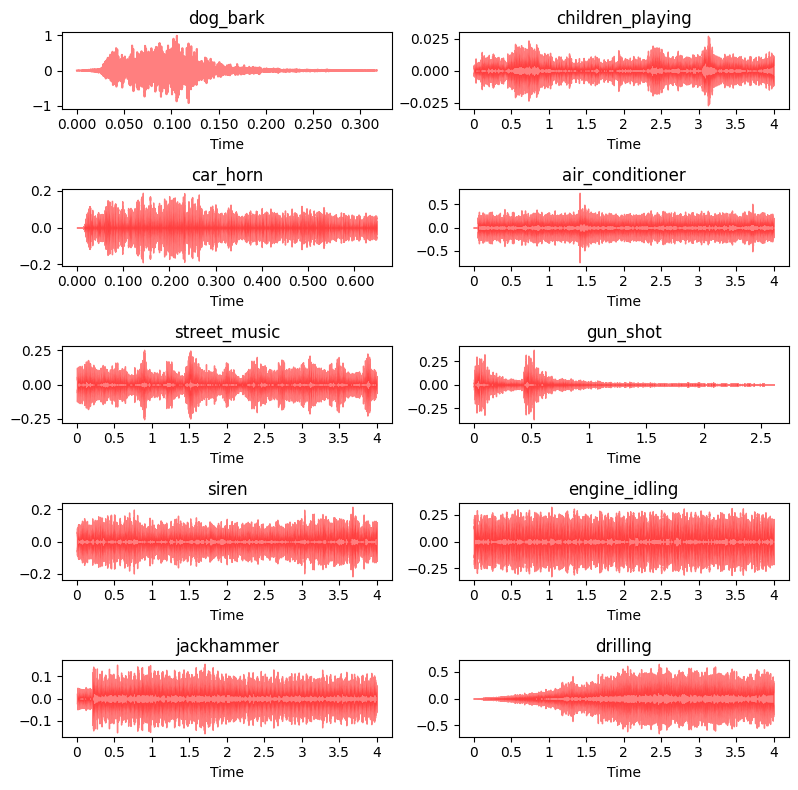

In [44]:
labels = df["class"].unique()

fig = plt.figure(figsize=(8,8))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    filtered_df = df[df["class"] == label]
    slice_file_name = filtered_df["slice_file_name"].iloc[0]
    fold = filtered_df["fold"].iloc[0]
    result = f"fold{fold}/{slice_file_name}"
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sr = librosa.load(os.path.join(AUDIO_DIR, result))
    librosa.display.waveshow(y = data, sr=sr, color="r", alpha=0.5, label='Harmonic')
    print(result)
     
plt.tight_layout()  # This will adjust spacing between subplots to prevent overlap
plt.show()  # This will display the plot

**Diversity in sample properties**
*  Number of channels  
*  Sample rates
*  Bit depths

In [45]:
audiodata = []
#Iterrows used to iterate over DataFrame rows as (index, Series) pairs. Each row is returned as a Series object, and you can access the values of the Series to process each row individually.
for index, row in df.iterrows():
    
    file_name = os.path.join(AUDIO_DIR,'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data = read_file_properties(filename = file_name)
    audiodata.append(data)
    # Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels', 'sample_rate', 'bit_depth', 'avg_rms', 'length_in_seconds', 'length_in_samples'])

In [46]:
audiodf.head()

# num of channels 
print("Channels: ")
print(audiodf.num_channels.value_counts(normalize=True))

# sample rates 
print("Sample Rates: ")
print(audiodf.sample_rate.value_counts(normalize=True))

# bit depth
print("Bit Depth: ")
print(audiodf.bit_depth.value_counts(normalize=True))

# length in samples
print("Samples: ")
print(audiodf.length_in_samples.value_counts())

# RMS
# print(audiodf.avg_rms.describe())

Channels: 
num_channels
2    0.915369
1    0.084631
Name: proportion, dtype: float64
Sample Rates: 
sample_rate
44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: proportion, dtype: float64
Bit Depth: 
bit_depth
16    0.659414
24    0.315277
32    0.019354
8     0.004924
4     0.001031
Name: proportion, dtype: float64
Samples: 
length_in_samples
176400    4523
192000    2120
384000     460
96000       83
64000       40
          ... 
138048       1
51587        1
47866        1
45844        1
154614       1
Name: count, Length: 1107, dtype: int64


### Preprocessing with Librosa
* Resample to common sample rate
* Bit-depth Normalization
* Mix-down to mono channel
* Cut the length to 2sec

In [47]:
# Resample
filename = AUDIO01

# Librosa load does resample, mono and bit depth conversion.
scipy_sample_rate, scipy_audio = wav.read(filename) 
librosa_audio, librosa_sample_rate = librosa.load(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate) 

Original sample rate: 48000
Librosa sample rate: 22050


In [48]:
#Bit-depth 
# also known as bit resolution, refers to the number of bits used to represent each sample in a digital audio file.
# Librosa’s load function will also normalise the data so it's values range between -1 and 1. This removes the complication of the dataset having a wide range of bit-depths.

print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -27967 to 26427
Librosa audio file min~max range: -0.8536738 to 0.8049574


Scipy audio shape: (192000,), Librosa audio shape: (88200,)


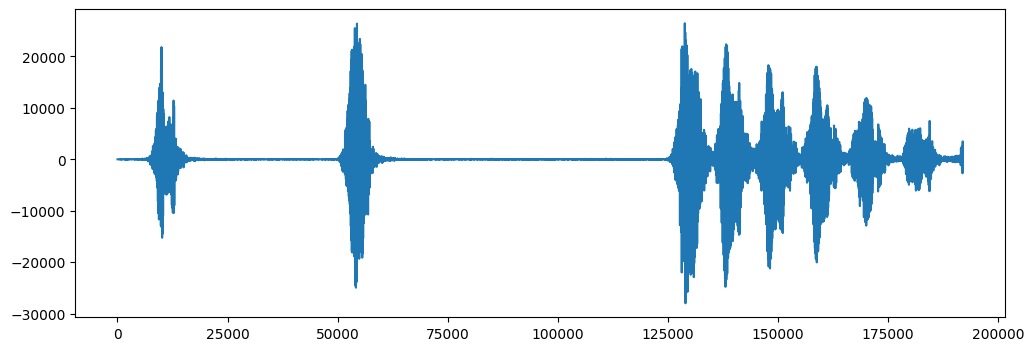

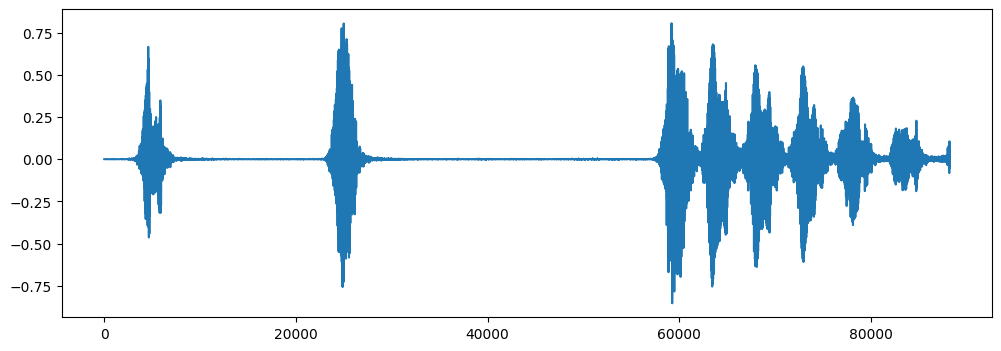

In [49]:
# Mix down to mono

# Original audio with 3 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

# Librosa audio with channels merged 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

print(f"Scipy audio shape: {scipy_audio.shape}, Librosa audio shape: {librosa_audio.shape}")

In [50]:
# Slice for common length of 3 seconds
def slice_audio(librosa_audio, librosa_sample_rate = 22050):
    SAMPLE_LENGTH = 1 * librosa_sample_rate

    librosa_audio_sliced = librosa_audio[:SAMPLE_LENGTH]
    if len(librosa_audio) < SAMPLE_LENGTH:
        # print(f"Audio length {len(librosa_audio)} is less than 2 seconds. Padding with zeros.")
        # np.pad specifies the number of values to add at the beginning and the end of the librosa_audio array.
        # 0 -> no padding in the beginning.
        # SAMPLE_LENGTH - len(librosa_audio) -> number of zeros to end, ensuring the total length is 2 seconds.
        librosa_audio_sliced = np.pad(librosa_audio, (0, SAMPLE_LENGTH - len(librosa_audio)), constant_values=0)
    return librosa_audio_sliced

# print(f"Librosa audio before: {librosa_audio.shape} and after: {slice_audio(librosa_audio).shape}")

In [51]:
from IPython.display import Audio

Audio(data=slice_audio(librosa_audio), rate=librosa_sample_rate)

# ______________________________________________________________________________
## <i>FEATURE EXTRACTION:</i>

### Option 3
**Extract Mel-Spectrogram**

In [52]:
def extract_mel_spectrogram(audio_path):
    
    audio_file, librosa_sample_rate = librosa.load(audio_path)
    audio_file = slice_audio(audio_file, librosa_sample_rate)

    spectrogram = librosa.feature.melspectrogram(y = audio_file, sr=librosa_sample_rate, n_mels=128, dtype=np.float32)
    spectrogram = (librosa.power_to_db(spectrogram, ref=np.max))
    #librosa.display.specshow(spectrogram, sr=librosa_sample_rate, x_axis='time')

    # spectrogram = tf.expand_dims(spectrogram, axis = 2)

    return spectrogram

(128, 44)


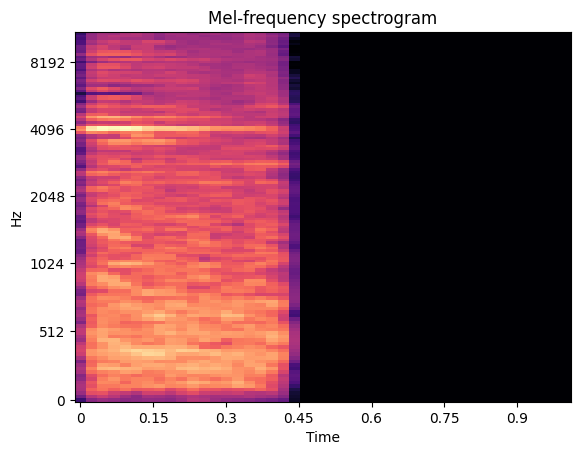

In [53]:
# Test the Fourier transform
#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
row = df.iloc[11]

file = os.path.join(AUDIO_DIR, "fold" + str(row["fold"]) + "\\" + str(row["slice_file_name"]))
audio_file, librosa_sample_rate = librosa.load(file)
audio_file = slice_audio(audio_file, librosa_sample_rate)

spectrogram = librosa.feature.melspectrogram(y=audio_file, sr=librosa_sample_rate, n_mels=128, fmax = 8000)
fig, ax = plt.subplots()
spectrogram = (librosa.power_to_db(spectrogram, ref=np.max))
librosa.display.specshow(spectrogram, sr=librosa_sample_rate, x_axis='time', ax=ax, y_axis='mel')
ax.set(title='Mel-frequency spectrogram')
print(spectrogram.shape)

In [54]:
features = []

#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
for index, row in df.iterrows():
    file = os.path.join(AUDIO_DIR, "fold" + str(row["fold"]) + "\\" + str(row["slice_file_name"]))
    class_label = row["class"]
    data = extract_mel_spectrogram(file)
    
    features.append([data, class_label])
    
featuresdf = pd.DataFrame(features, columns=["features", "class_label"])
print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  8732  files


In [55]:
featuresdf.head()

,features,class_label
0,"[[-72.605446, -66.374306, -65.6224, -72.332405...",dog_bark
1,"[[-13.365751, -7.4208865, -10.928555, -13.2661...",children_playing
2,"[[-20.765318, -11.720047, -6.213472, -8.025827...",children_playing
3,"[[-8.770987, -8.673233, -14.111397, -12.597261...",children_playing
4,"[[-7.4083996, -4.318716, -6.2382545, -7.011562...",children_playing


In [56]:
featuresdf.iloc[0]["features"].shape

(128, 44)

#### <i>END OF FEATURE EXTRACTION</i>
# ______________________________________________________________________________

**Convert the data and labels**
<p>We will use sklearn.preprocessing.LabelEncoder to encode the categorical text data into model-understandable numerical data.</p>
<p><i>Meaning, that every class has a column, which is either 0 or 1</i></p>

In [57]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.features.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

### Split the dataset

In [58]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

<b>Store the preprocessed data</b>

In [59]:
### store the preprocessed data for use in the next notebook

%store x_train 
%store x_test 
%store y_train 
%store y_test 
%store yy 
%store le

Stored 'x_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'yy' (ndarray)
Stored 'le' (LabelEncoder)
